**Monte Carlo: on policy control using Exploration Starts**

In this notebook, we implement the first-visit MC control for a Blackjack player using exploration starts (Sutton&Barto book, Example 5.2) [adapted from Shangtong Zhang repository]

In [ ]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns # to show colormaps
from tqdm import tqdm # to show progress of loops

Define actions [hit, stick]

In [ ]:
# actions: hit or stand
ACTION_HIT = 0
ACTION_STAND = 1  #  "stick" in the book
ACTIONS = [ACTION_HIT, ACTION_STAND]

Policies for dealer

In [ ]:
# policy for dealer
POLICY_DEALER = np.zeros(22)
for i in range(12, 17):
    POLICY_DEALER[i] = ACTION_HIT
for i in range(17, 22):
    POLICY_DEALER[i] = ACTION_STAND

Define auxiliary functions

In [ ]:
# get a new card
def get_card():
    card = np.random.randint(1, 14)
    card = min(card, 10)
    return card

# get the value of a card (11 for ace).
def card_value(card_id):
    return 11 if card_id == 1 else card_id

Function that generate one episode of the Blackjack game

In [ ]:
# play a game
# @policy_player: specify policy for player
# @initial_state: [whether player has a usable Ace, sum of player's cards, one card of dealer]
# @initial_action: the initial action
def play(policy_player, initial_state=None, initial_action=None):
    # player status

    # sum of player
    player_sum = 0

    # trajectory of player
    player_trajectory = []

    # whether player uses Ace as 11
    usable_ace_player = False

    # dealer status
    dealer_card1 = 0
    dealer_card2 = 0
    usable_ace_dealer = False

    if initial_state is None:
        # generate a random initial state

        # initialize cards of player
        while player_sum < 12:
            # if sum of player is less than 12, always hit
            card = get_card()
            player_sum += card_value(card)
            usable_ace_player = (card == 1)

        # Always use an ace as 11, unless there are two.
        # If the player's sum is larger than 21, he must hold two aces.
        if player_sum > 21:
            assert player_sum == 22
            # use one Ace as 1 rather than 11
            player_sum -= 10

        # initialize cards of dealer, suppose dealer will show the first card he gets
        dealer_card1 = get_card()
        dealer_card2 = get_card()

    else:
        # use specified initial state
        usable_ace_player, player_sum, dealer_card1 = initial_state
        dealer_card2 = get_card()

    # initial state of the game
    state = [usable_ace_player, player_sum, dealer_card1]

    # initialize dealer's sum
    dealer_sum = card_value(dealer_card1) + card_value(dealer_card2)
    usable_ace_dealer = 1 in (dealer_card1, dealer_card2)
    # if the dealer's sum is larger than 21, he must hold two aces.
    if dealer_sum > 21:
        assert dealer_sum == 22
        # use one Ace as 1 rather than 11
        dealer_sum -= 10
    assert dealer_sum <= 21
    assert player_sum <= 21

    # game starts!

    # player's turn
    while True:
        if initial_action is not None:
            action = initial_action
            initial_action = None
        else:
            # get action based on current sum
            action = policy_player(usable_ace_player, player_sum, dealer_card1)

        # track player's trajectory for importance sampling
        player_trajectory.append([(usable_ace_player, player_sum, dealer_card1), action])

        if action == ACTION_STAND:
            break
        # if hit, get new card
        card = get_card()
        # Keep track of the ace count. the usable_ace_player flag is insufficient alone as it cannot
        # distinguish between having one ace or two.
        ace_count = int(usable_ace_player)
        if card == 1:
            ace_count += 1
        player_sum += card_value(card)
        # If the player has a usable ace, use it as 1 to avoid busting and continue.
        while player_sum > 21 and ace_count:
                player_sum -= 10
                ace_count -= 1
        # player busts
        if player_sum > 21:
            return state, -1, player_trajectory
        assert player_sum <= 21
        usable_ace_player = (ace_count == 1)

    # dealer's turn
    while True:
        # get action based on current sum
        action = POLICY_DEALER[dealer_sum]
        if action == ACTION_STAND:
            break
        # if hit, get a new card
        new_card = get_card()
        ace_count = int(usable_ace_dealer)
        if new_card == 1:
            ace_count += 1
        dealer_sum += card_value(new_card)
        # If the dealer has a usable ace, use it as 1 to avoid busting and continue.
        while dealer_sum > 21 and ace_count:
                dealer_sum -= 10
                ace_count -= 1
        # dealer busts
        if dealer_sum > 21:
            return state, 1, player_trajectory
        usable_ace_dealer = (ace_count == 1)

    # compare the sum between player and dealer
    assert player_sum <= 21 and dealer_sum <= 21
    if player_sum > dealer_sum:
        return state, 1, player_trajectory
    elif player_sum == dealer_sum:
        return state, 0, player_trajectory
    else:
        return state, -1, player_trajectory


Implement on-policy Monte Carlo control algorithm for a set of pre-generated episodes with exploration starts

In [ ]:
# Monte Carlo with Exploring Starts
def monte_carlo_es(episodes):
    # (playerSum, dealerCard, usableAce, action)
    state_action_values = np.zeros((10, 10, 2, 2))
    # initialze counts to 1 to avoid division by 0
    state_action_pair_count = np.ones((10, 10, 2, 2))

    # current policy is greedy
    def current_policy(usable_ace, player_sum, dealer_card):
        usable_ace = int(usable_ace)
        player_sum -= 12
        dealer_card -= 1
        # get argmax of the average returns(s, a)
        values_ = state_action_values[player_sum, dealer_card, usable_ace, :] / \
                  state_action_pair_count[player_sum, dealer_card, usable_ace, :]
        return np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

    # play for several episodes
    for episode in tqdm(range(episodes)):
        # for each episode, use a randomly initialized state and action
        initial_state = [bool(np.random.choice([0, 1])),
                       np.random.choice(range(12, 22)),
                       np.random.choice(range(1, 11))]
        initial_action = np.random.choice(ACTIONS)
        _, reward, trajectory = play(current_policy, initial_state, initial_action)
        for (usable_ace, player_sum, dealer_card), action in trajectory:
            usable_ace = int(usable_ace)
            player_sum -= 12
            dealer_card -= 1
            # update values of state-action pairs
            state_action_values[player_sum, dealer_card, usable_ace, action] += reward
            state_action_pair_count[player_sum, dealer_card, usable_ace, action] += 1

    return state_action_values / state_action_pair_count

Generate Fig. 5.2: Optimal policy estimated with MC control with Exploration starts

100%|██████████| 500000/500000 [01:00<00:00, 8231.45it/s]


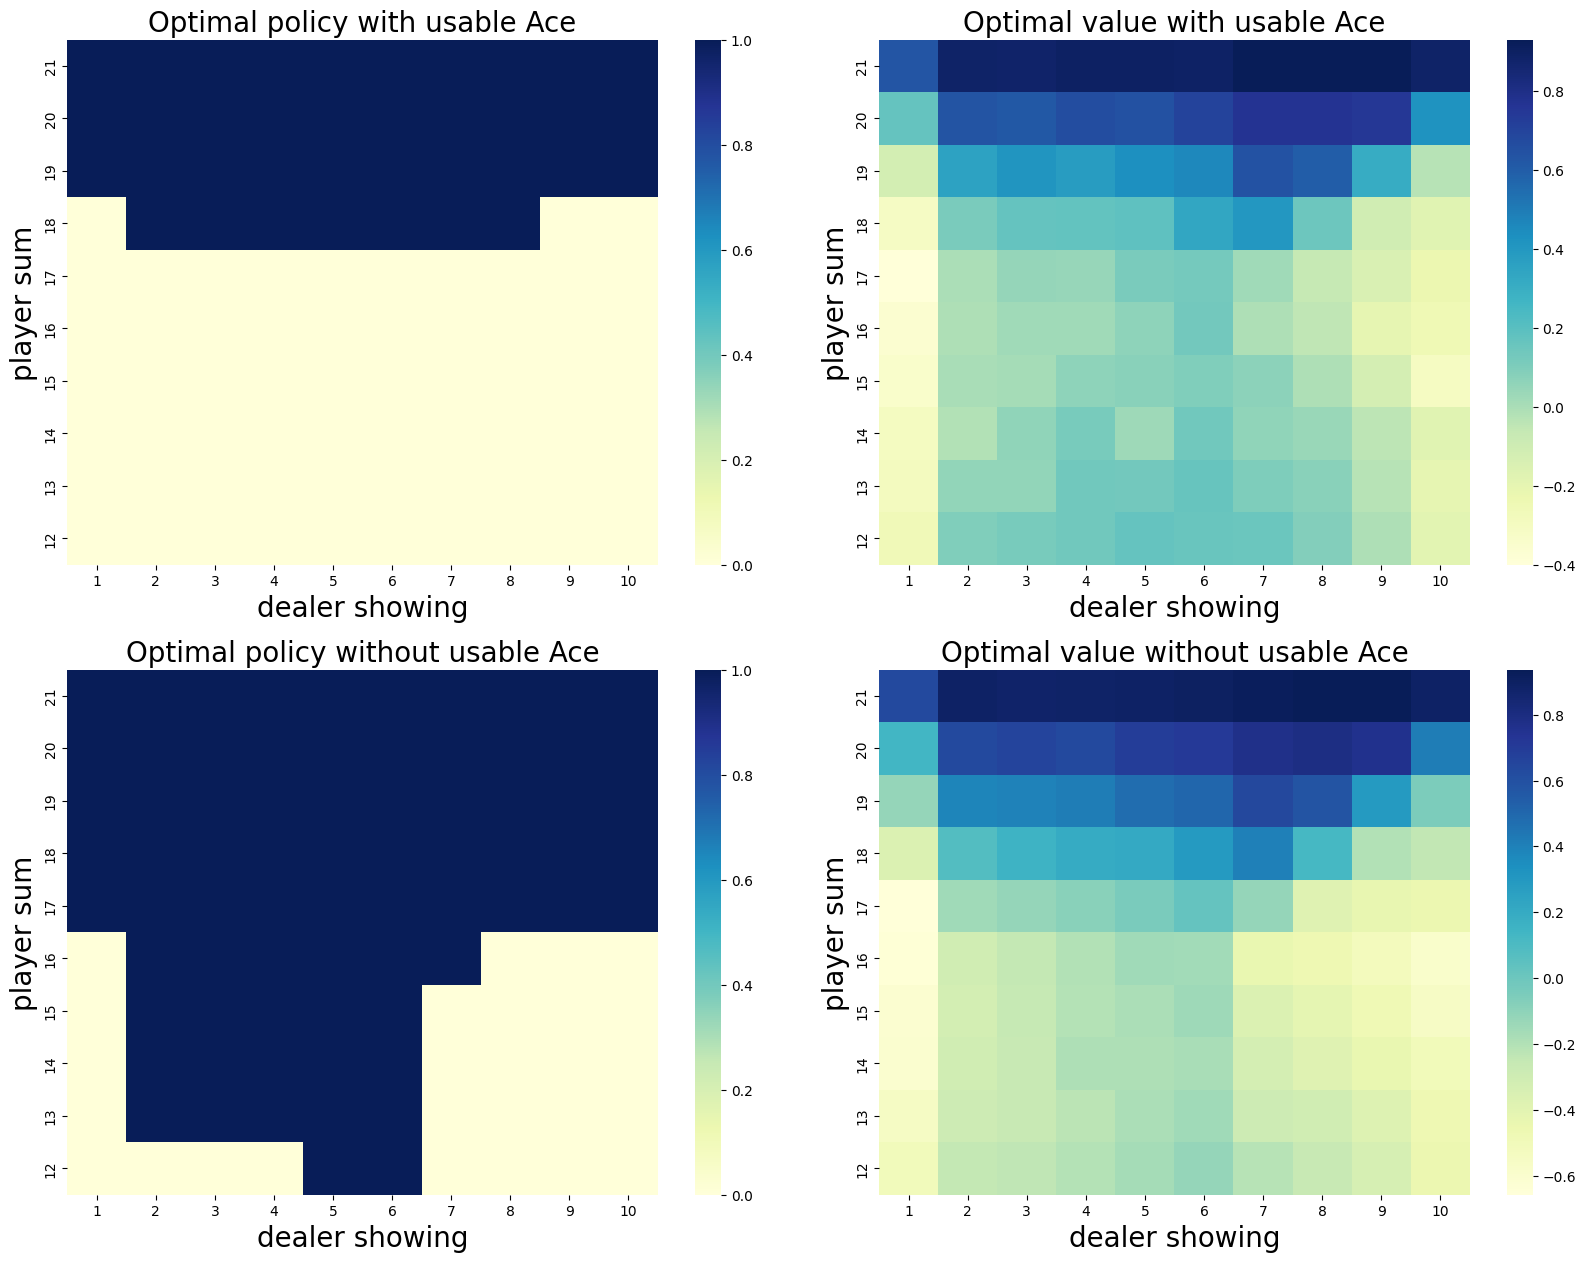

In [16]:
state_action_values = monte_carlo_es(500000)

state_value_no_usable_ace = np.max(state_action_values[:, :, 0, :], axis=-1)
state_value_usable_ace = np.max(state_action_values[:, :, 1, :], axis=-1)

# get the optimal policy
action_no_usable_ace = np.argmax(state_action_values[:, :, 0, :], axis=-1)
action_usable_ace = np.argmax(state_action_values[:, :, 1, :], axis=-1)

images = [action_usable_ace,
          state_value_usable_ace,
          action_no_usable_ace,
          state_value_no_usable_ace]

titles = ['Optimal policy with usable Ace',
          'Optimal value with usable Ace',
          'Optimal policy without usable Ace',
          'Optimal value without usable Ace']

fig, ax = plt.subplots(2, 2, figsize=(20, 15))
plt.subplots_adjust(wspace=0.1, hspace=0.2)
ax = ax.flatten()

for image, title, axis in zip(images, titles, ax):
    fig = sns.heatmap(np.flipud(image), cmap="YlGnBu", ax=axis, xticklabels=range(1, 11),
                      yticklabels=list(reversed(range(12, 22))))
    fig.set_ylabel('player sum', fontsize=20)
    fig.set_xlabel('dealer showing', fontsize=20)
    fig.set_title(title, fontsize=20)

